In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tsai.all as ts
import torch
from torch import nn
from my_utilities import time_frequency_analysis, mma_Partition, time_frequency_analysis_output_1s
from sklearn.linear_model import RidgeClassifierCV

import time

In [1]:
(20000-2000)/6000

3.0

In [ ]:
srate = 2000
new_srate = 200
sec = 1 # time step length
ele = pd.read_csv('data/ele_4_60_hz.csv', header = None, index_col = None).to_numpy()
# shape = (4, 15, 2, 20000, 14)

ele = np.reshape(
    ele, (20000,15,4,2,14), order = 'F').transpose([2,1,3,0,4])[:,:,:,srate::srate//new_srate,:]


ear_ele = ele[...,:8].astype(np.float32).reshape(-1,int(200 * sec),8)
head_ele = ele[...,8:].astype(np.float32).reshape(-1,int(200 * sec),6)
# labels = np.repeat([0,1,2,3], ear_ele.shape[0]//4)

In [4]:
ear_ele.shape

(1080, 200, 8)

In [ ]:
# np.roll(np.arange(24).reshape(3,8), 1)
def roll_window(x, y, stride = 100):
    '''
    args:
        x(sample, channel, time_step): numpy ndarray, must contain the axis which want to be rolled
        axis: int, the specific axis
        stride: int, step length
    '''
    x_temp = x.reshape(x.shape[0], x.shape[1],-1,stride)  
    strided_x = np.asarray([np.roll(x_temp, shift = i, axis = 2).reshape(x.shape[0], x.shape[1], -1)\
                            for i in np.arange(x_temp.shape[2])])
    y = np.tile(y, x_temp.shape[2])
    return strided_x.reshape(-1, x.shape[1], x.shape[2]), y

In [5]:
# batches, channels, time step
ear_ele = ele[...,:8].astype(np.float32).reshape(-1,int(200 * sec),8).transpose([0,2,1])
head_ele = ele[...,8:].astype(np.float32).reshape(-1,int(200 * sec),6).transpose([0,2,1])

# z-score
head_ele = (head_ele - head_ele.mean(axis = 2)[...,np.newaxis])\
                /head_ele.std(axis = 2)[...,np.newaxis]

ear_ele = (ear_ele - ear_ele.mean(axis = 2)[...,np.newaxis])\
                /ear_ele.std(axis = 2)[...,np.newaxis]

y = np.repeat([0,1,2,3], int(ear_ele.shape[0]/4))

################################ TFA #########################
print('begin to TFA')
mask = np.unique(np.array(list(range(5,59,5))+
                          list(range(7,59,7))+
                          list(range(9,59,9))+
                          list(range(11,59,11))))-2
# time frequency analysis for ear-EEG
temp_ear_ele = []
for i in ear_ele:
    _,_,temp = time_frequency_analysis(
        i.T, srate = new_srate, max_freq = 60, min_freq = 2, num_freq = 59, fwhm = 0.35)
    # _,_,temp = time_frequency_analysis_output_1s(
    #     i.T, srate = new_srate, max_freq = 60, min_freq = 2, num_freq = 59, fwhm = 1)    
    temp_ear_ele.append(temp)
    
# if use mask
ear_ele = np.asarray(temp_ear_ele)[:,mask,:]

# # if do not use mask
# ear_ele = np.asarray(temp_ear_ele)
del temp_ear_ele
##############################################################


ear_X_train, ear_X_test, ear_y_train, ear_y_test = train_test_split(ear_ele, y, test_size=0.1)
# head_X_train, head_X_test, head_y_train, head_y_test = train_test_split(head_ele, y, test_size=0.1)
# ################# DATA generate ##############################
# ear_X_train, ear_y_train = roll_window(ear_X_train, ear_y_train)
# ear_X_train, ear_y_train = shuffle(ear_X_train, ear_y_train)
##############################################################
ear_ele, ear_y, ear_splits = ts.combine_split_data([ear_X_train, ear_X_test], [ear_y_train, ear_y_test])

begin to TFA


In [6]:
ear_X_train.shape

(972, 27, 200)

In [ ]:
# batch_tfms = [ts.TSStandardize(by_sample=True)]
# tfms  = [None, [ts.Categorize()]]
# dls = ts.get_ts_dls(ear_ele, ear_y, 
#                  splits=ear_splits, 
#                  tfms=tfms, drop_last=False, 
#                  shuffle_train=False, batch_tfms=batch_tfms, bs=10_000)

# model = ts.build_ts_model(ts.ROCKET, dls=dls)

# X_train, y_train = ts.create_rocket_features(dls.train, model)
# X_valid, y_valid = ts.create_rocket_features(dls.valid, model)
# X_train.shape, X_valid.shape

In [7]:
def cross_validation(x, y, cv_number = 20, test_size = 0.1, gen = False):
    acc = []
    batch_tfms = [ts.TSStandardize(by_sample=True)]
    tfms  = [None, [ts.Categorize()]]
    
    for _ in np.arange(cv_number):
        x, y = shuffle(x, y)
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
        
        if gen:
            X_train, y_train = roll_window(X_train, y_train)
            X_train, y_train = shuffle(X_train, y_train)
            
        ear_X, ear_y, splits = ts.combine_split_data([X_train, X_test], [y_train, y_test])
        dls = ts.get_ts_dls(ear_X, ear_y, 
                         splits=splits, 
                         tfms=tfms, drop_last=False, 
                         shuffle_train=False, batch_tfms=batch_tfms, bs=10_000)        
        model = ts.build_ts_model(ts.ROCKET, dls=dls)
        
        X_train, y_train = ts.create_rocket_features(dls.train, model)
        X_valid, y_valid = ts.create_rocket_features(dls.valid, model)
        X_train.shape, X_valid.shape
    
        ridge = RidgeClassifierCV(alphas=np.logspace(-8, 8, 17), normalize=True)
        ridge.fit(X_train, y_train)
        print(f'alpha: {ridge.alpha_:.2E}  train: {ridge.score(X_train, y_train):.5f}  valid: {ridge.score(X_valid, y_valid):.5f}')
        acc.append(ridge.score(X_valid, y_valid))
        
    return acc

In [13]:
# np.asarray(acc_total).mean(axis = 1)

array([0.7       , 0.76041667, 0.68958333, 0.68958333, 0.70833333,
       0.71666667, 0.68333333, 0.69166667, 0.67916667, 0.67916667])

In [8]:
acc_total = []
for i in np.arange(10):
    acc_total.append(cross_validation(ear_ele, ear_y, cv_number = 20, test_size = 0.1))
    print(f'step:{i}')

# acc = cross_validation(ear_ele, ear_y, cv_number = 20, test_size = 0.1, gen = False)

alpha: 1.00E+02  train: 0.62346  valid: 0.46296
alpha: 1.00E+01  train: 0.90535  valid: 0.44444
alpha: 1.00E+02  train: 0.60597  valid: 0.49074
alpha: 1.00E+02  train: 0.61317  valid: 0.48148
alpha: 1.00E+02  train: 0.60802  valid: 0.48148
alpha: 1.00E+02  train: 0.59979  valid: 0.47222
alpha: 1.00E+02  train: 0.61317  valid: 0.42593
alpha: 1.00E+02  train: 0.60802  valid: 0.47222
alpha: 1.00E+02  train: 0.61831  valid: 0.53704
alpha: 1.00E+02  train: 0.60700  valid: 0.50000
alpha: 1.00E+02  train: 0.61934  valid: 0.41667
alpha: 1.00E+02  train: 0.61420  valid: 0.50000
alpha: 1.00E+02  train: 0.61934  valid: 0.47222
alpha: 1.00E+02  train: 0.60185  valid: 0.43519
alpha: 1.00E+02  train: 0.62140  valid: 0.33333
alpha: 1.00E+02  train: 0.61008  valid: 0.42593
alpha: 1.00E+02  train: 0.59877  valid: 0.54630
alpha: 1.00E+02  train: 0.61523  valid: 0.37963
alpha: 1.00E+02  train: 0.60391  valid: 0.53704
alpha: 1.00E+02  train: 0.61523  valid: 0.43519
step:0
alpha: 1.00E+02  train: 0.60082  

In [20]:
np.asarray(acc).mean()

0.6597222222222222

In [28]:
# pd.DataFrame(acc, columns=['1s']).to_csv(r'result/ROCKET_ACC.csv', index= None)

In [44]:
pd.concat([pd.read_csv(r'result/ROCKET_ACC.csv', header = 0),pd.DataFrame(acc, columns=['3s'])], 
          axis = 1).to_csv(r'result/ROCKET_ACC.csv', index= None)

<AxesSubplot: >

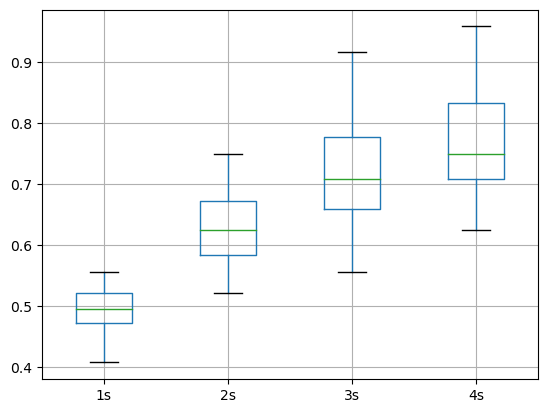

In [49]:
pd.read_csv(r'result/ROCKET_ACC.csv', header = 0).boxplot()

In [23]:
pd.read_csv(r'result/ROCKET_ACC.csv', header = 0).to_numpy()[:,0].mean()

0.49675925925

In [9]:
# batches, channels, time step
ear_ele = ele[...,:8].astype(np.float32).reshape(-1,int(200 * sec),8).transpose([0,2,1])
head_ele = ele[...,8:].astype(np.float32).reshape(-1,int(200 * sec),6).transpose([0,2,1])

# z-score
head_ele = (head_ele - head_ele.mean(axis = 2)[...,np.newaxis])\
                /head_ele.std(axis = 2)[...,np.newaxis]

ear_ele = (ear_ele - ear_ele.mean(axis = 2)[...,np.newaxis])\
                /ear_ele.std(axis = 2)[...,np.newaxis]

y = np.repeat([0,1,2,3], int(ear_ele.shape[0]/4))

################################ TFA #########################
print('begin to TFA')
mask = np.unique(np.array(list(range(5,59,5))+
                          list(range(7,59,7))+
                          list(range(9,59,9))+
                          list(range(11,59,11))))-2
# time frequency analysis for ear-EEG
temp_ear_ele = []
for i in ear_ele:
    _,_,temp = time_frequency_analysis(
        i.T, srate = new_srate, max_freq = 60, min_freq = 2, num_freq = 59, fwhm = 0.7)
    # _,_,temp = time_frequency_analysis_output_1s(
    #     i.T, srate = new_srate, max_freq = 60, min_freq = 2, num_freq = 59, fwhm = 1)    
    temp_ear_ele.append(temp)
    
# if use mask
ear_ele = np.asarray(temp_ear_ele)[:,mask,:]

# # if do not use mask
# ear_ele = np.asarray(temp_ear_ele)
del temp_ear_ele
##############################################################


ear_X_train, ear_X_test, ear_y_train, ear_y_test = train_test_split(ear_ele, y, test_size=0.1)
# head_X_train, head_X_test, head_y_train, head_y_test = train_test_split(head_ele, y, test_size=0.1)
# ################# DATA generate ##############################
# ear_X_train, ear_y_train = roll_window(ear_X_train, ear_y_train)
# ear_X_train, ear_y_train = shuffle(ear_X_train, ear_y_train)
##############################################################
ear_ele, ear_y, ear_splits = ts.combine_split_data([ear_X_train, ear_X_test], [ear_y_train, ear_y_test])

begin to TFA


In [10]:
acc_total_2 = []
for i in np.arange(10):
    acc_total_2.append(cross_validation(ear_ele, ear_y, cv_number = 20, test_size = 0.1))
    print(f'step:{i}')


alpha: 1.00E+02  train: 0.59671  valid: 0.47222
alpha: 1.00E+02  train: 0.57716  valid: 0.60185
alpha: 1.00E+02  train: 0.58642  valid: 0.48148
alpha: 1.00E+02  train: 0.61523  valid: 0.38889
alpha: 1.00E+01  train: 0.87551  valid: 0.47222
alpha: 1.00E+02  train: 0.60082  valid: 0.54630
alpha: 1.00E+02  train: 0.59979  valid: 0.43519
alpha: 1.00E+02  train: 0.59568  valid: 0.50000
alpha: 1.00E+02  train: 0.59979  valid: 0.42593
alpha: 1.00E+02  train: 0.60597  valid: 0.40741
alpha: 1.00E+02  train: 0.58333  valid: 0.53704
alpha: 1.00E+01  train: 0.85802  valid: 0.51852
alpha: 1.00E+02  train: 0.58745  valid: 0.52778
alpha: 1.00E+02  train: 0.59259  valid: 0.45370
alpha: 1.00E+02  train: 0.59156  valid: 0.49074
alpha: 1.00E+02  train: 0.58848  valid: 0.56481
alpha: 1.00E+01  train: 0.86420  valid: 0.45370
alpha: 1.00E+02  train: 0.58025  valid: 0.59259
alpha: 1.00E+02  train: 0.58539  valid: 0.53704
alpha: 1.00E+02  train: 0.59671  valid: 0.49074
step:0
alpha: 1.00E+01  train: 0.87654  

In [12]:
np.asarray(acc_total).mean(axis = 1)
np.asarray(acc_total_2).mean(axis = 1)

array([0.4625    , 0.45694444, 0.45833333, 0.45648148, 0.45601852,
       0.48981481, 0.45046296, 0.45601852, 0.4462963 , 0.4837963 ])

array([0.49490741, 0.49953704, 0.47592593, 0.4912037 , 0.48981481,
       0.50740741, 0.5125    , 0.49351852, 0.4837963 , 0.48564815])